In [68]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import IsolationForest

In [69]:
#read the file directly from github repository
url = "https://raw.githubusercontent.com/Juuuuuuupiter/Neospectra_Soil/main/SE_AI4SH_2024_DS.csv"
csv_file_path = url
df = pd.read_csv(url)

In [70]:
#Set Directory; the folder where your csv and other data are, and you need to save data later
##os.chdir('C:/Users/hsfa0259/Desktop/Neospectra')

In [71]:
# Load CSV file for spectra data
##csv_file_path = "C:/Users/hsfa0259/Desktop/Neospectra/SE_AI4SH_2024_DS.csv"  # location to the site data
df_site_data = pd.read_csv(csv_file_path, index_col=0) # assuming the first column is index column

Preprocessing

In [72]:
# === Step 1: Filtering using Savitzky-Golay ===
def apply_savitzky_golay(df, window_length=5, polyorder=2, mode='nearest'):
    """
    Apply Savitzky-Golay filter to smooth spectral data.
    
    :param df: DataFrame containing spectral data (wavelengths as columns)
    :param window_length: Window size for the filter (must be odd)
    :param polyorder: Polynomial order for smoothing
    :return: Smoothed DataFrame
    """
     # Ensure window_length is valid
    if df.shape[0] < window_length:
        raise ValueError(f"window_length ({window_length}) cannot be greater than the number of rows ({df.shape[0]})")

    # Apply Savitzky-Golay filter row-wise
    filtered_array = np.apply_along_axis(
        lambda row: savgol_filter(row, window_length, polyorder, mode="nearest"),
        axis=1,
        arr=df
    )

    # Convert back to DataFrame
    return pd.DataFrame(filtered_array, columns=df.columns, index=df.index)

# === Step 2: Scatter Correction using Standard Normal Variate (SNV) ===
def snv(input_data):
    """
    Applies Standard Normal Variate (SNV) to each row in the dataset.

    Parameters:
    - input_data (pd.DataFrame or np.ndarray): Spectral data.

    Returns:
    - pd.DataFrame: SNV-transformed data with the same shape as input.
    """

    # Ensure input is a NumPy array
    if isinstance(input_data, pd.DataFrame):
        input_array = input_data.to_numpy()
    else:
        input_array = input_data

    # Check for non-numeric data
    if not np.issubdtype(input_array.dtype, np.number):
        raise ValueError("SNV function received non-numeric data.")

    # Compute SNV (normalize each row)
    mean = np.mean(input_array, axis=1, keepdims=True)
    std_dev = np.std(input_array, axis=1, keepdims=True)
    snv_array = (input_array - mean) / std_dev

    # Convert back to DataFrame if original was a DataFrame
    if isinstance(input_data, pd.DataFrame):
        return pd.DataFrame(snv_array, columns=input_data.columns, index=input_data.index)
    return snv_array


# === Step 3: Compute First Derivatives ===
def compute_first_derivative(df):
    """
    Compute the first derivative of spectral data.
    
    :param df: DataFrame containing spectral data
    :return: First derivative DataFrame
    """
    if isinstance(df, np.ndarray):  # Convert to DataFrame if it became an array
        df = pd.DataFrame(df)

    # Get the derivatives
    derivative = df.diff(axis=1, periods=1)

    # Drop first column since diff creates NaN
    derivative.drop(axis=1, columns=derivative.columns[0], inplace=True)

    return derivative

# === Step 4: Remove Outliers using Isolation Forest ===
def remove_outliers(df, contamination=0.1):
    """
    Remove outliers using Isolation Forest.
    
    :param df: DataFrame containing spectral data
    :param contamination: Proportion of data expected to be outliers
    :return: Cleaned DataFrame
    """
    model = IsolationForest(contamination=contamination, random_state=42)
    labels = model.fit_predict(df)
    return df[labels == 1]  # Keep only inliers

In [73]:
#you need to replace your dataframe with specified colomns here
spectral_data_savitzky = apply_savitzky_golay(df_site_data) #specify where the csv file is located
spectral_data_snv = snv(spectral_data_savitzky)
spectral_data_first_derivative = compute_first_derivative(spectral_data_snv)
spectral_data_cleaned = remove_outliers(spectral_data_first_derivative)
print(spectral_data_cleaned.head())

                                005-organic_0-20  003-organic_20-50  \
Sample_Name                                                           
spectral_data.2464.42955642491         -1.574845           0.428866   
spectral_data.2456.18732125368         -1.579307           0.435496   
spectral_data.2448.00003428936         -1.585060           0.440972   
spectral_data.2439.86714787568         -1.592774           0.443793   
spectral_data.2431.78812161009         -1.602282           0.443086   

                                004-organic_20-50  003-organic_0-20  \
Sample_Name                                                           
spectral_data.2464.42955642491           1.293802          0.817535   
spectral_data.2456.18732125368           1.304512          0.813768   
spectral_data.2448.00003428936           1.315789          0.810024   
spectral_data.2439.86714787568           1.327332          0.805465   
spectral_data.2431.78812161009           1.338846          0.799623   

    

Change the column name from "Spectral_data." to numerical values.

In [74]:
import re

new_columns = []
for col in df_site_data.iloc[0]:
    if isinstance(col, str) and col.startswith("spectral_data."):
        # Remove "spectral_data." and convert to float
        wavelength = float(re.sub(r"^spectral_data\.", "", col))
        new_columns.append(wavelength)
    else:
        new_columns.append(col)

df_site_data.columns = new_columns
print(df_site_data.columns)
# Drop first row (now used as header)
##df_site_data = df_site_data.drop(index=0).reset_index(drop=True)

Index([39.34300767, 31.71952036,  29.7702316, 43.69658502, 38.32757311,
       40.55154678, 34.29514547, 35.29504614, 30.50570266, 52.20205336,
       39.74673061, 46.92529331, 40.63280261, 43.19891225, 43.77703176,
       47.56871482, 40.91026164, 39.70714915, 40.29223959, 32.25898032,
       51.11127074, 46.82507034, 41.99286082, 28.38305364,  41.8789543,
       38.52629608, 38.34646048, 50.72228745, 38.70843707, 44.49766667,
       43.68914646, 41.38268462, 42.74539009, 43.40679039, 41.45080676,
       45.96502734, 38.85966625,  43.8609827, 34.74814456, 37.53333875,
       45.50194928, 38.99843445, 33.38208211, 43.62708244, 44.31128724],
      dtype='float64')


Data visulaization

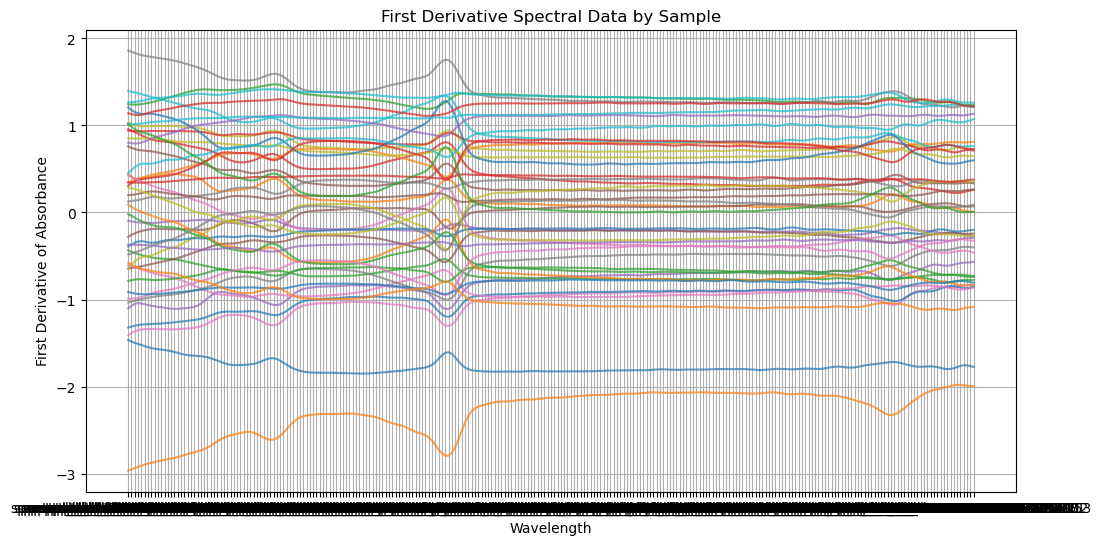

In [83]:
import matplotlib.pyplot as plt

# Plot the first derivative spectra for each sample
plt.figure(figsize=(12, 6))

# x-axis: wavelengths (index), y-axis: each sample (column)
for col in spectral_data_first_derivative.columns:
    plt.plot(
        spectral_data_first_derivative.index.astype(str),  # wavelengths as strings for x-axis
        spectral_data_first_derivative[col].values,
        alpha=0.7
    )

plt.xlabel("Wavelength")
plt.ylabel("First Derivative of Absorbance")
plt.title("First Derivative Spectral Data by Sample")
plt.grid(True)
plt.show()

In [ ]:
#note:the data set is too big for altair to creat plot, matplotlib is more suitable
##import matplotlib.pyplot as plt

# Convert wide table to long format
##spectral_long = pd.DataFrame(
    ##spectral_data_cleaned,  # absorbance values
    ##columns=df_site_data.columns   # wavelengths
##).melt(
    ##var_name='Wavelength (nm)',
    ##value_name='calculated absorbance'
)

##chart = alt.Chart(spectral_long).mark_line().encode(
    ##x='Wavelength (nm):Q',
    ##y='calculated absorbance:Q',
    ##color='Sample_Name:N'
##).properties(
    ##title='Spectral Data by Sample'
)

##chart


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

See https://altair-viz.github.io/user_guide/large_datasets.html for information on how to plot large datasets, including how to install third-party data management tools and, in the right circumstance, disable the restriction

alt.Chart(...)

Load soil property data